In [1]:
import random
import numpy as np
import pandas as pd
import time
import re
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import nltk

In [2]:
from nltk import pos_tag, word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paigelee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Load data

#### Penn Treebank

In [3]:
treebankstr = '''CC	Coordinating conjunction
DT	Determiner
EX	Existential there 
IN	Preposition or subordinating conjunction
LS	List item marker
MD	Modal
PDT	Predeterminer
PRP	Personal pronoun
PRP$	Possessive pronoun
RP	Particle
WDT	Wh-determiner
WP	Wh-pronoun
WP$	Possessive wh-pronoun
WRB	Wh-adverb
TO	to
CD	Cardinal number
FW	Foreign word
JJ	Adjective
JJR	Adjective, comparative
JJS	Adjective, superlative
NN	Noun, singular or mass
NNS	Noun, plural
NNP	Proper noun, singular
NNPS	Proper noun, plural
POS	Possessive ending
RB	Adverb
RBR	Adverb, comparative
RBS	Adverb, superlative
SYM	Symbol
UH	Interjection
VB	Verb, base form
VBD	Verb, past tense
VBG	Verb, gerund or present participle
VBN	Verb, past participle
VBP	Verb, non-3rd person singular present
VBZ	Verb, 3rd person singular present'''

In [4]:
pos2str = dict()
for m in treebankstr.split('\n'):
    a,b = m.split('\t')
    pos2str[a]=b

#### Dataframe

In [252]:
df = pd.read_excel('data/Jul21_3379_articles.xlsx',index_col=0)
df = df.reset_index()
df = df.drop_duplicates(subset=['title'])
print(len(df))
df.head()

3379


,index,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt
0,0,apnews.com,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
1,1,apnews.com,2021-10-12 07:00:00,https://apnews.com/cdfd9b277f6bade5697e0427429...,Blinken reaffirms US support for Ukraine amid ...,English,United States,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",western,6032
2,2,apnews.com,2021-10-11 07:00:00,https://apnews.com/90b50e622cefcbaeba96cb5e716...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318
3,3,apnews.com,2021-10-06 07:00:00,https://apnews.com/0b689a7baaac58603e4d7453aa5...,Ukraine Holocaust center names Nazi Babi Yar k...,English,United States,"KYIV, Ukraine (AP) — The presidents of Ukraine...",western,3646
4,4,apnews.com,2021-10-13 07:00:00,https://apnews.com/89d2455274aad5fe166445a5f82...,Ukraine separatist areas overwhelmed by soarin...,English,United States,"KYIV, Ukraine (AP) — The Russia-backed separat...",western,2184


In [7]:
records = df.to_dict('records')

### Initialize StanfordPOSTagger

In [8]:
# from nltk import StanfordTagger
# from nltk.tag import StanfordPOSTagger

In [9]:
# model_filename = 'stanford-postagger-full-2020-11-17/models/english-bidirectional-distsim.tagger'
# path_to_jar = 'stanford-postagger-full-2020-11-17/stanford-postagger.jar'

In [10]:
# st = StanfordPOSTagger(model_filename=model_filename,path_to_jar=path_to_jar)

In [11]:
# text_tok = nltk.word_tokenize('What is the airspeed of an unladen swallow ?')

In [12]:
# st.tag(text_tok)

## Parse dataframe text

In [13]:
###
tokenCount = 0
for rec in records:
    tokenCount += len(word_tokenize(rec['text']))
print(tokenCount, 'total tokens in dataframe.')

1799389 total tokens in dataframe.


In [99]:
# process texts
def tm_tokenize(txt):
    word_corrections = [
    # ('said',''),
    ('Reuters',''),
    ('REUTERS',''),
    ('Thomson',''),
    ('AP', ''),
    ('Sputnik',''),
    ('TASS',''),
    ('BBC',''),
    ('Kiev ','Kyiv '),
    ('Lugansk','Luhansk'),
    ('Donbas','Donbass'),
    ('U.S.','US'),
    ('United States','US'),
    ('Aleksandr', 'Alexander')
    ]
    takeoutif = [
        'This story has been corrected to show',
        'contributed to this report',
        'All rights reserved',
        'not responsible for the material quoted in these press',
        'Follow all AP stories',
        'https',
        'dedicated page',
        'Follow AP’s coverage',
        '©',
        'This video can not be played',
        '© 2022 Reuters.'
        'contributed reporting',
        'Please include your name, age and location with any submission.',
        'See here for',
        'contributed.',
        'reported from',
        'reaching billions of people worldwide every day',
        'quotes delayed a minimum',
        'contributed to this story.',
        'pic.twitter.com',
        'radio@sputniknews.com',
        'Screen for heightened risk individual and entities globally to help uncover hidden risks in business relationships and human networks.',
        'Browse an unrivalled portfolio of',
        'Access unmatched financial',
        'Reuters',
        'Build the strongest argument relying on',
        'The most comprehensive solution to manage all',
        'Access unmatched financial data',
        'The industry leader for online information for tax'
        ]
    for a, b in word_corrections:
        txt = txt.replace(a, b)
    for string in takeoutif:
        if string in txt:
            return None
    if not txt[0].isalpha() and txt[0] not in ['"',"'",'“']:
        return None
    if len(txt) <= 50:
        return None
    return txt

In [102]:
allTokenCt = dict()
allTokenCt['russian'] = 0
allTokenCt['western'] = 0

for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        for token, pos in tokenizedTaggedText:
            allTokenCt[rec['category']] += 1
allTokenCt

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.


{'russian': 915736, 'western': 746780}

## Sentiment

In [211]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentiText

In [207]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/paigelee/nltk_data...


True

In [241]:
# %%time

sentiRecs = []
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    artSenti = {
        'pos' : 0, 'neu' : 0, 'neg' : 0
    }
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(text)
        for k in ['pos','neu','neg']:
            artSenti[k] += ss[k]
    for k in artSenti:
        artSenti[k] = artSenti[k]/len(sents)
    sentiRecs.append(artSenti)

sentOnlyDf = pd.DataFrame.from_records(sentiRecs)
sentiDf = pd.concat([df, sentOnlyDf],axis=1)

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.


In [253]:
sentiDf = pd.concat([df, sentOnlyDf],axis=1)

In [254]:
sentiDf

,index,newsOutlet,dateSeen,url,title,language,sourceCountry,text,category,textCharCt,pos,neu,neg
0,0,apnews.com,2021-10-12 07:00:00,https://apnews.com/article/technology-business...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318,0.077714,0.819619,0.055048
1,1,apnews.com,2021-10-12 07:00:00,https://apnews.com/cdfd9b277f6bade5697e0427429...,Blinken reaffirms US support for Ukraine amid ...,English,United States,"KYIV, Ukraine (AP) — U.S. Secretary of State A...",western,6032,0.066667,0.811033,0.088967
2,2,apnews.com,2021-10-11 07:00:00,https://apnews.com/90b50e622cefcbaeba96cb5e716...,"EU , Ukraine to discuss military training and ...",English,United States,BRUSSELS (AP) — The European Union is consider...,western,3318,0.077714,0.819619,0.055048
3,3,apnews.com,2021-10-06 07:00:00,https://apnews.com/0b689a7baaac58603e4d7453aa5...,Ukraine Holocaust center names Nazi Babi Yar k...,English,United States,"KYIV, Ukraine (AP) — The presidents of Ukraine...",western,3646,0.019000,0.769038,0.096577
4,4,apnews.com,2021-10-13 07:00:00,https://apnews.com/89d2455274aad5fe166445a5f82...,Ukraine separatist areas overwhelmed by soarin...,English,United States,"KYIV, Ukraine (AP) — The Russia-backed separat...",western,2184,0.028286,0.828643,0.071643
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3374,39,tass.com,2021-10-13 07:00:00,https://tass.com/world/1349287,Russia curious what results Kiev expects from ...,English,NaN,"MOSCOW, October 13. /TASS/. Russia remains cur...",russian,335,0.033000,0.285000,0.015000
3375,1215,tass.com,2022-01-25 08:00:00,https://tass.com/world/1392599,"Ukrainian envoy , UN Secretary General address...",English,NaN,"UNITED NATIONS, January 25. /TASS/. Permanent ...",russian,310,0.000000,0.333333,0.000000
3376,573,tass.com,2021-12-09 08:00:00,https://tass.com/world/1373255,Talks on peaceful settlement of Ukrainian cris...,English,NaN,"MOSCOW, December 9. /TASS/. The EU joined the ...",russian,264,0.042000,0.291333,0.000000
3377,753,tass.com,2021-12-23 08:00:00,https://tass.com/economy/1380079,Naftogaz expects West to impose sanctions on b...,English,NaN,"KIEV, December 23. /TASS/. Naftogaz of Ukraine...",russian,262,0.000000,0.320000,0.013333


## Big words analysis

In [137]:
%%time
bwCtDict = dict()
wordLength = dict()
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        
        for token, pos in tokenizedTaggedText:
            if token.isalpha():
                wordLength.setdefault(rec['category'], [])
                wordLength[rec['category']].append(len(token))
                
            if len(token) > 6:
                bwCtDict.setdefault(token.lower(), {'western' : 0, 'russian' : 0})
                bwCtDict[token.lower()][rec['category']] += 1
bwFreqDict = dict()
for token in bwCtDict:
    bwFreqDict[token] = dict()
    for cat in ['western','russian']:
        bwFreqDict[token][cat] = bwCtDict[token][cat]/allTokenCt[cat]

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 54.2 s, sys: 849 ms, total: 55 s
Wall time: 56.2 s


In [143]:
# most different bigword freqs
bwlist = []
for token in bwFreqDict:
    bwlist.append((abs(bwFreqDict[token]['russian'] - bwFreqDict[token]['western']),token))
sortedBws = sorted(bwlist,reverse=True)[:50]
sortedBws

[(0.0014361960274217051, 'donbasss'),
 (0.0013832826227362781, 'security'),
 (0.0010597705503828114, 'according'),
 (0.0010285021905467942, 'situation'),
 (0.0009336552326583065, 'agreements'),
 (0.000845065446902766, 'ukrainian'),
 (0.0007923185516061089, 'foreign'),
 (0.0007198051195311363, 'russian'),
 (0.0006927292434835137, 'spokesman'),
 (0.000627091958373344, 'eastern'),
 (0.0006215452602245518, 'ministry'),
 (0.0006044755531886376, 'officials'),
 (0.0005697169127690328, 'stressed'),
 (0.0005639799983936345, 'alleged'),
 (0.0005378655448778334, 'republics'),
 (0.0005196027340518058, 'provocations'),
 (0.00050964105411204, 'proposals'),
 (0.0004835512667040985, 'allegations'),
 (0.00046433464901436287, 'luhansk'),
 (0.0004524904250503551, 'january'),
 (0.0004431512996574103, 'however'),
 (0.00043489869379623853, 'washington'),
 (0.00043148216002030946, 'government'),
 (0.00042856469817250845, 'guarantees'),
 (0.0004281938993639828, 'earlier'),
 (0.0004278434791942484, 'repeatedly

In [144]:
for a,b in sortedBws:
    if bwFreqDict[b]['western'] > bwFreqDict[b]['russian']:
        print(b, bwFreqDict[b])

eastern {'western': 0.001451565387396556, 'russian': 0.000824473429023212}
officials {'western': 0.0012520421007525644, 'russian': 0.0006475665475639267}
government {'western': 0.00126141567797745, 'russian': 0.0008299335179571404}
belarus {'western': 0.0008195184659471331, 'russian': 0.0003942184210296417}
zelenskyy {'western': 0.00046867886124427543, 'russian': 5.3508871552499845e-05}
separatists {'western': 0.00036824767669193067, 'russian': 7.644124507499978e-06}
separatist {'western': 0.00036690859423123273, 'russian': 1.2012195654642823e-05}
germany {'western': 0.00110608211253649, 'russian': 0.0007567683262424979}


In [145]:
for a,b in sortedBws:
    if bwFreqDict[b]['western'] < bwFreqDict[b]['russian']:
        print(b, bwFreqDict[b])

donbasss {'western': 5.222421596721926e-05, 'russian': 0.0014884202433889243}
security {'western': 0.00183052572377407, 'russian': 0.003213808346510348}
according {'western': 0.00043520179972682716, 'russian': 0.0014949723501096386}
situation {'western': 0.0004981386753796299, 'russian': 0.0015266408659264242}
agreements {'western': 0.00015399448298026192, 'russian': 0.0010876497156385684}
ukrainian {'western': 0.002303221832400439, 'russian': 0.003148287279303205}
foreign {'western': 0.0015533356544095986, 'russian': 0.0023456542060157075}
russian {'western': 0.0055330887276038455, 'russian': 0.006252893847134982}
spokesman {'western': 0.0002879027290500549, 'russian': 0.0009806319725335687}
ministry {'western': 0.00046064436648008783, 'russian': 0.0010821896267046397}
stressed {'western': 9.641393717025095e-05, 'russian': 0.0006661308499392838}
alleged {'western': 0.00018077613219422053, 'russian': 0.000744756130587855}
republics {'western': 0.00011516109162002196, 'russian': 0.00065

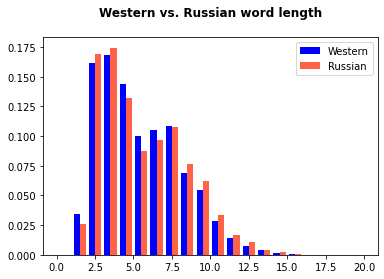

In [132]:
n_bins = 20
x = [np.array(wordLength['western']), np.array(wordLength['russian'])]
colors = ['blue', 'tomato']
plt.hist(x, n_bins, density = True, range=(0,20),
         histtype ='bar',
         color = colors,
         label = ['Western', 'Russian'])
plt.legend(prop ={'size': 10})
plt.title('Western vs. Russian word length\n',
          fontweight ="bold")
plt.show()

## WPS Analysis

In [146]:
%%time

wpsDict = dict()
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        cat = rec['category']
        wpsDict.setdefault(cat, [])
        wpsDict[cat].append(len(tokenizedTaggedText))

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 50.5 s, sys: 509 ms, total: 51 s
Wall time: 51.4 s


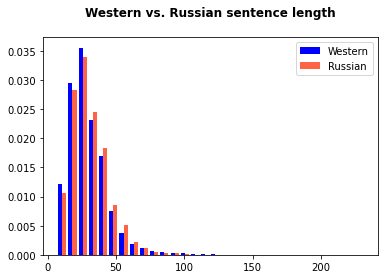

In [149]:
n_bins = 30
x = [np.array(wpsDict['western']), np.array(wpsDict['russian'])]
colors = ['blue', 'tomato']
plt.hist(x, n_bins, density = True,
         histtype ='bar',
         color = colors,
         label = ['Western', 'Russian'])
plt.legend(prop ={'size': 10})
plt.title('Western vs. Russian sentence length\n',
          fontweight ="bold")
plt.show()

## Clout

In [204]:
%%time
# fewer first-person singular, and more first-person plural and second-person singular pronouns

personalPronouns = set()
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
            
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        for token, pos in tokenizedTaggedText:
            token = token.lower()
            if pos in ['PRP', 'PRP$'] and token.isalpha():
                personalPronouns.add(token)

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 1min 46s, sys: 3.79 s, total: 1min 50s
Wall time: 2min 10s


In [195]:
%%time
# fewer first-person singular, and more first-person plural and second-person singular pronouns

ppCts = dict ()
fps = ['i','me','my','mine']
fpp = ['we','us','our','ours']
sps = ['you', 'yours',]
ppWordCts = dict()
for word in fps + fpp + sps:
    ppWordCts[word] = {'western' : 0, 'russian' : 0}
    
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        cat = rec['category']
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        for token, pos in tokenizedTaggedText:
            token = token.lower()
            # first person sing
            if token in fps:
                ppCts.setdefault('fps', {'western' : 0, 'russian' : 0})
                ppCts['fps'][cat] += 1
                ppWordCts[token][cat] += 1
            # first person plural
            if token in fpp:
                ppCts.setdefault('fpp', {'western' : 0, 'russian' : 0})
                ppCts['fpp'][cat] += 1
                ppWordCts[token][cat] += 1
            # second person singular
            if token in sps:
                ppCts.setdefault('sps', {'western' : 0, 'russian' : 0})
                ppCts['sps'][cat] += 1
                ppWordCts[token][cat] += 1
                
ppFreqDict = dict()
for token in ppCts:
    ppFreqDict[token] = dict()
    for cat in ['western','russian']:
        ppFreqDict[token][cat] = ppCts[token][cat]/allTokenCt[cat]
        
ppTokenFreqs = dict()
for token in ppWordCts:
    ppTokenFreqs[token] = dict()
    for cat in ['western','russian']:
        ppTokenFreqs[token][cat] = ppWordCts[token][cat]/allTokenCt[cat]

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 1min 35s, sys: 1.53 s, total: 1min 37s
Wall time: 1min 39s


In [196]:
# more first-person plural, similar first-person singular, fewer second-person singular pronouns
# not # fewer first-person singular, and more first-person plural and second-person singular pronouns
ppFreqDict

{'fpp': {'western': 0.00979271003508396, 'russian': 0.011555732219766395},
 'fps': {'western': 0.001506467768285171, 'russian': 0.001486236207815353},
 'sps': {'western': 0.0005490238088861512, 'russian': 0.00041933483012571306}}

In [200]:
for key in ppTokenFreqs:
    diff = ppTokenFreqs[key]['russian'] -ppTokenFreqs[key]['western']
    if diff > .00001:
        print(key, 'diff west -> russ', diff)

i diff west -> russ 0.0001103070624678766
we diff west -> russ 0.00043181754772687094
us diff west -> russ 0.0009907782183655343
our diff west -> russ 0.0003494491720498665


## Authentic (not deception)

Predicting deception from linguistic styles -- Specifically, deceptive communication was character- ized by the use
of fewer first-person singular pronouns (e.g., I, me, my), fewer third-person pronouns (e.g., he, she, they), 
more negative emotion words (e.g., hate, anger, enemy), fewer exclusive words (e.g., but, except, without), and more motion verbs (e.g., walk, move, go).

In [185]:
motionVerbs = ['action*', 'advanc*', 'approach', 'approached', 'approaches', 'approaching', 'arrival*', 'arrive', 'arrived', 'arrives', 'arriving', 'attend', 'attended', 'attending', 'attends', 'backward*', 'behavio*', 'bounce', 'bounces', 'bouncing', 'brief', 'briefly', 'bring', 'bringing', 'brings', 'brought', 'came', 'car', 'carried', 'carrier*', 'carries', 'carry', 'carrying', 'catch', 'caught', 'change', 'changed', 'changes', 'changing', 'circulat*', 'climb*', 'closes', 'closing', 'come', 'comes', 'coming', 'commute*', 'commuting', 'crawl*', 'cruis*', 'dance', 'danced', 'dances', 'dancing', 'deliver*', 'depart', 'departed', 'departing', 'departs', 'departure*', 'descend', 'descended', 'descending', 'descends', 'drift*', 'drive', 'driven', 'drives', 'driving', 'drop', 'drove', 'dump*', 'enter', 'entered', 'entering', 'enters', 'escap*', 'evad*', 'explor*', 'fall', 'fallen', 'falling', 'falls', 'fell', 'flapping', 'fled', 'flee', 'fleeing', 'flees', 'flew', 'flies', 'flight*', 'flow', 'flowed', 'flowing', 'flown', 'flows', 'fly', 'flying', 'follow', 'followed', 'following', 'follows', 'forward', 'forwarded', 'forwarding', 'forwards', 'gesture*', 'glide', 'gliding', 'go', 'goes', 'going', 'gon', 'gone', 'gonna', 'gravitate*', 'grew', 'grow', 'growing', 'grown', 'growth', 'hang', 'headed', 'headin*', 'hik*', 'hop', 'increas*', 'jog*', 'journey*', 'jump', 'jumped', 'jumping', 'jumps', 'launch*', 'lead', 'leading', 'leads', 'leave', 'leaves', 'leaving', 'led', 'lunge*', 'lunging', 'motion*', 'move', 'moved', 'movement*', 'mover*', 'moves', 'moving', 'orbit', 'pass', 'passed', 'passes', 'passing', 'pivot', 'pranc*', 'pull*', 'push', 'pushe*', 'pushing', 'put', 'puts', 'putting', 'quickly', 'ran', 'rapid', 'receiv*', 'remov*', 'replace*', 'replacing', 'revolve', 'revolved', 'revolves', 'revolving', 'ridden', 'ride', 'rides', 'riding', 'rise*', 'rising', 'rode', 'roll', 'rolling', 'rotate', 'rotated', 'rotates', 'rotating', 'rotation*', 'run', 'runner*', 'running', 'runs', 'rush*', 'sank', 'send', 'sender', 'sending', 'sends', 'sent', 'shake*', 'shook', 'sinking', 'slid', 'slide', 'slides', 'sliding', 'slip', 'slipping', 'slow', 'slowed', 'slowing', 'slowly', 'slows', 'spin', 'spiral', 'sprint*', 'spun', 'stay', 'stayed', 'staying', 'stays', 'step', 'stepp*', 'steps', 'stir', 'stirred', 'stirring', 'stirs', 'stumble', 'stumbled', 'stumbles', 'stumbling', 'sunk', 'swam', 'sway', 'swim*', 'swing', 'swinging', 'swings', 'swivel*', 'swung', 'threw', 'throw', 'thrown', 'throws', 'transfer*', 'transport*', 'travel', 'traveled', 'traveler*', 'traveling', 'travels', 'trembl*', 'turn', 'turned', 'turns', 'twirl*', 'twist*', 'untwist*', 'vibrate', 'visit', 'visited', 'visiting', 'visits', 'waft*', 'walk', 'walked', 'walking', 'walks', 'wave', 'went', 'zoom']

In [187]:
exclusiveWords = ['ban', 'bar', 'block', 'boycott', 'eliminate', 'ignore', 'omit', 'ostracize', 'preclude', 'prevent', 'prohibit', 'refuse', 'reject', 'remove', 'suspend', 'bate', 'blacklist', 'bounce', 'debar', 'disallow', 'eject', 'embargo', 'evict', 'except', 'interdict', 'obviate', 'occlude', 'oust', 'proscribe', 'repudiate', 'sideline', 'veto', 'refuse', 'but', 'except', 'without', 'disregard']

In [201]:
# %%time
# fewer first-person singular, fewer third-person pronoun, more negative emotion, fewer exclusive, more motion


fps = ['i','me','my','mine','myself']
tp = ['he','she','they','him','her','them','himself','herself','themselves']
# motionVerbs
# exclusiveWords
attrCategoryCts = dict ()
attrWordCts = dict()

for word in fps + tp + motionVerbs + exclusiveWords:
    attrWordCts[word] = {'western' : 0, 'russian' : 0}
    
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        cat = rec['category']
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        for token, pos in tokenizedTaggedText:
            token = token.lower()
            # first person sing
            if token in fps:
                attrCategoryCts.setdefault('fps', {'western' : 0, 'russian' : 0})
                attrCategoryCts['fps'][cat] += 1
                attrWordCts[token][cat] += 1
            # third person 
            if token in tp:
                attrCategoryCts.setdefault('tp', {'western' : 0, 'russian' : 0})
                attrCategoryCts['tp'][cat] += 1
                attrWordCts[token][cat] += 1
            # motion verbs
            mvFound = False
            for stem in motionVerbs:
                if token == stem:
                    mvFound = True
                elif stem.replace('*','') in token:
                    mvFound = True
                else:
                    continue
            if mvFound:
                attrCategoryCts.setdefault('mv', {'western' : 0, 'russian' : 0})
                attrCategoryCts['mv'][cat] += 1
                attrWordCts.setdefault(token, {'western' : 0, 'russian' : 0})
                attrWordCts[token][cat] += 1
                
            # exclu words
            if token in exclusiveWords:
                attrCategoryCts.setdefault('exclu', {'western' : 0, 'russian' : 0})
                attrCategoryCts['exclu'][cat] += 1
                attrWordCts[token][cat] += 1
                
attrFreqDict = dict()
for token in attrCategoryCts:
    attrFreqDict[token] = dict()
    for cat in ['western','russian']:
        attrFreqDict[token][cat] = attrCategoryCts[token][cat]/allTokenCt[cat]
        
attrTokenFreqs = dict()
for token in attrWordCts:
    attrTokenFreqs[token] = dict()
    for cat in ['western','russian']:
        attrTokenFreqs[token][cat] = attrWordCts[token][cat]/allTokenCt[cat]

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.


In [203]:
# fewer first-person singular, fewer third-person pronoun, more negative emotion, fewer exclusive, more motion
# fewer motion words in russian
# fewer third person 
# fewer exclusive
# fewer/about the same first person singular
attrFreqDict

{'mv': {'western': 0.03468625297945847, 'russian': 0.02921038377873099},
 'tp': {'western': 0.009930635528535847, 'russian': 0.007824307442319621},
 'exclu': {'western': 0.004459144594124106, 'russian': 0.0025280211764089214},
 'fps': {'western': 0.0015198585928921503, 'russian': 0.0014916962967492814}}

## Function words

In [20]:
function_str = '''CC
DT
EX
IN
LS
MD
PDT
PRP
PRP$
RP
WDT
WP
WP$
WRB
TO'''
function_pos = [f.strip() for f in function_str.split('\n')]

In [21]:
%%time
# get function words used above a certain total threshold
threshold = 5

fwCts = dict()
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    tokenizedTaggedText = pos_tag(word_tokenize(rec['text']))
    for token, pos in tokenizedTaggedText:        
        token = token.lower()
        if not token.isalpha():
            continue
        if pos in function_pos:
            fwCts.setdefault(token, {'western' : 0, 'russian' : 0})
            fwCts[token][rec['category']] += 1
to_delete = []
for fw in fwCts:
    if fwCts[fw]['western'] + fwCts[fw]['russian'] < 25:
        to_delete.append(fw)
for td in to_delete:
    del fwCts[td]

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 50.1 s, sys: 154 ms, total: 50.3 s
Wall time: 50.3 s


In [42]:
%%time
# function word spread across W and R

funcWordsPerSent = []
allTokenCt = dict()
allTokenCt['russian'] = 0
allTokenCt['western'] = 0

for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        fwinSent = set()
        funcWordCt = 0
        ctDict = dict()
        for fw in fwCts:
            ctDict.setdefault(fw, 0)
        for token, pos in tokenizedTaggedText:
            allTokenCt[rec['category']] += 1
            token = token.lower()
            if token in fwCts:
                funcWordCt += 1
                fwinSent.add(token)
                ctDict[token] += 1
        recDict = {
            'category' : rec['category'],
            'percentFunction' : funcWordCt/len(tokenizedTaggedText),
            'funcTokens' : list(fwinSent),
            'sentTokens' : tokenizedTaggedText,
            'sentText' : text
        }
        for fw in fwCts:
            recDict[fw] = ctDict[fw]/len(tokenizedTaggedText)
            
        funcWordsPerSent.append(recDict)
fwDf = pd.DataFrame.from_records(funcWordsPerSent)
fwDf.head()

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 1min 9s, sys: 2.47 s, total: 1min 12s
Wall time: 1min 14s


,category,percentFunction,funcTokens,sentTokens,sentText,the,a,to,amid,between,...,towards,neither,above,half,plus,away,alongside,shall,wo,ca
0,western,0.241379,"[its, a, and, between, amid, the, to]","[(BRUSSELS, NNP), ((, (), (), )), (—, VBZ), (T...",BRUSSELS () — The European Union is considerin...,0.034483,0.034483,0.034483,0.034483,0.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,western,0.333333,"[on, a, from, for, the, with, to]","[(Acting, VBG), (on, IN), (a, DT), (request, N...",Acting on a request from Ukraine for help with...,0.074074,0.074074,0.037037,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,western,0.400000,"[will, on, in, a, of, during, the, with]","[(The, DT), (topic, NN), (will, MD), (be, VB),...",The topic will be discussed during a summit Tu...,0.080000,0.040000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,western,0.454545,"[in, how, of, yet, could, the, to]","[(The, DT), (results, NNS), (of, IN), (the, DT...",The results of the mission have yet to be anal...,0.136364,0.000000,0.090909,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,western,0.375000,"[will, s, in, and, back, for, the, which, to]","[(One, CD), (official, NN), (said, VBD), (the,...",One official said the EU’s political and secur...,0.093750,0.000000,0.031250,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
totalCts = []
for fw in fwCts:
    totalCts.append((fwCts[fw]['western']+fwCts[fw]['russian'], fw))
top10funcTokens = sorted(totalCts, reverse=True)[:10]

In [54]:
top10funcTokens

[(99822, 'the'),
 (48688, 'to'),
 (44000, 'of'),
 (43341, 'and'),
 (34741, 'in'),
 (29231, 'a'),
 (23077, 'that'),
 (19112, 'on'),
 (12940, 'for'),
 (11621, 'with')]

In [59]:
# t-test in differences of function word frequency
# 2 t-test
for ct, funcToken in top10funcTokens:
    westernPOSdf = fwDf[fwDf['category'] == 'western'][funcToken]
    russianPOSdf = fwDf[fwDf['category'] == 'russian'][funcToken]

    coeff = scipy.stats.ttest_ind(np.array(westernPOSdf), np.array(russianPOSdf), axis=0)
    if coeff.pvalue < .01 and russianPOSdf.mean() > westernPOSdf.mean():
    # if True:
        print(funcToken, fwCts[funcToken])
        print('western mean/median', westernPOSdf.mean(),westernPOSdf.median())
        print('russian mean/median', russianPOSdf.mean(),russianPOSdf.median())
        print('p-value', coeff.pvalue)
        print('t-statistic', coeff.statistic)
        print()

the {'western': 39966, 'russian': 59856}
western mean/median 0.04905731991952553 0.045454545454545456
russian mean/median 0.06338687059627339 0.05970149253731343
p-value 0.0
t-statistic -39.30138807179572

to {'western': 22130, 'russian': 26558}
western mean/median 0.026392945364066823 0.021739130434782608
russian mean/median 0.027790653999793427 0.025
p-value 7.123179034544495e-08
t-statistic -5.388770111913035

of {'western': 18990, 'russian': 25010}
western mean/median 0.02198400204403752 0.0
russian mean/median 0.025456097131343898 0.02127659574468085
p-value 4.186198222840848e-45
t-statistic -14.105896649720457

and {'western': 21668, 'russian': 21673}
western mean/median 0.021366907618023855 0.0
russian mean/median 0.022140690041414113 0.017543859649122806
p-value 0.0005415811201702623
t-statistic -3.4595035971420893

that {'western': 9437, 'russian': 13640}
western mean/median 0.011249513548401136 0.0
russian mean/median 0.014455768082605921 0.0
p-value 5.695093208694046e-71
t-s

In [87]:
# western mean/median 0.04905731991952553 0.045454545454545456
# russian mean/median 0.06338687059627339 0.05970149253731343
thedf = fwDf[fwDf['category'] == 'russian'][fwDf['the'] > .059][fwDf['the'] < .060]
thedf

/var/folders/jj/_szc94p56q91q_7c209d1d9w0000gn/T/ipykernel_9684/1366155633.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  thedf = fwDf[fwDf['category'] == 'russian'][fwDf['the'] > .059][fwDf['the'] < .060]


,category,percentFunction,funcTokens,sentTokens,sentText,the,a,to,amid,between,...,towards,neither,above,half,plus,away,alongside,shall,wo,ca
26668,russian,0.402985,"[you, on, in, s, him, but, and, out, of, who, ...","[(If, IN), (you, PRP), (doubt, VBP), (the, DT)...",If you doubt the credibility of the US governm...,0.059701,0.000000,0.059701,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27472,russian,0.296296,"[about, up, on, what, s, while, and, of, who, ...","[(Russia, NNP), (’, NNP), (s, VBD), ('Terror, ...",Russia’s 'Terror' Pipeline Britain’s tabloid p...,0.059259,0.000000,0.051852,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27772,russian,0.283582,"[about, so, on, or, but, from, of, his, the, t...","[(``, ``), (So, RB), (far, RB), (Macron, NNP),...","""So far Macron clearly lacks the character of ...",0.059701,0.000000,0.029851,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29017,russian,0.261905,"[on, what, s, a, and, of, for, into, there, th...","[(Посмотреть, JJ), (эту, NNP), (публикацию, NN...",Посмотреть эту публикацию в Instagram ...,0.059524,0.023810,0.011905,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29181,russian,0.343284,"[in, a, s, and, out, of, for, by, an, the, tha...","[(After, IN), (Russian, JJ), (troops, NNS), (c...",After Russian troops carried out drills in sou...,0.059701,0.014925,0.044776,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33962,russian,0.330508,"[a, while, across, if, over, at, s, from, she,...","[(Last, JJ), (Sunday, NNP), (,, ,), (she, PRP)...","Last Sunday, she confused the Baltic and Black...",0.059322,0.008475,0.025424,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41491,russian,0.253731,"[about, on, in, a, while, and, of, the, with, ...","[(Ukrainian, JJ), (Foreign, NNP), (Minister, N...",Ukrainian Foreign Minister Dmitry Kuleba disto...,0.059701,0.014925,0.014925,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
for rec in thedf.to_dict('records'):
    print(rec['sentText'])
    print([a for a in rec['sentTokens'] if a[0].lower() in 'the'])
    print()

If you doubt the credibility of the US government, of the British government, of other governments and want to find solace in information that the Russians are putting out, that is for you to do.” Price then moved on to other reporters’ questions, who also challenged him for evidence, but were more willing to accept Price’s response.
[('the', 'DT'), ('the', 'DT'), ('the', 'DT'), ('the', 'DT')]

Russia’s 'Terror' Pipeline Britain’s tabloid press have sounded the alarm about the Power of Siberia 2 project, with the Daily Express running back-to-back stories with the provocative headlines “Putin outsmarts EU as new China gas deal to pump ‘same amount’ as banned German pipeline” and “China tipped to copy Russia’s Ukraine tactics with Taiwan as pair link up to cause terror.” “Experts” cited by the articles claim, incredulously, that Russia may be deliberately “tinkering with gas supplies” to put pressure on the EU to approve Nord Stream 2, while at the same time looking east to China to giv

## All Penn Treebank POS

In [98]:
%%time
# get function words used above a certain total threshold
threshold = 25

counts = dict()
for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
        
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        for token, pos in tokenizedTaggedText:        
            token = token.lower()
            if not token.isalpha():
                continue
            counts.setdefault(pos, dict())
            counts[pos].setdefault(token, {'western' : 0, 'russian' : 0})
            counts[pos][token][rec['category']] += 1
to_delete = []
for pos in counts:
    for token in counts[pos]:
        if counts[pos][token]['western'] + counts[pos][token]['russian'] < threshold:
            to_delete.append((pos, token))
for dpos, dtoken in to_delete:
    del counts[dpos][dtoken]

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 53.7 s, sys: 689 ms, total: 54.4 s
Wall time: 55.1 s


In [103]:
%%time
# function word spread across W and R

posCatPerSent = []

for recIdx, rec in enumerate(records):
    if recIdx % 500 == 0:
        print(f'{recIdx}/{len(records)} recs parsed with NLTK.')
        
    sents = sent_tokenize(rec['text'])
    for text in sents:
        text = tm_tokenize(text)
        if text == None:
            continue
        tokenizedTaggedText = pos_tag(word_tokenize(text))
        ctDict = dict()
        for posType in counts:
            ctDict.setdefault(posType, 0)
        for token, pos in tokenizedTaggedText:
            token = token.lower()
            if not token.isalpha():
                continue
            if token in counts[pos]:
                ctDict[pos] += 1
        recDict = {
            'category' : rec['category'],
            'sentTokens' : tokenizedTaggedText,
            'sentText' : text
        }
        for posType in counts:
            recDict[posType] = ctDict[posType]/len(tokenizedTaggedText)
            
        posCatPerSent.append(recDict)
posDf = pd.DataFrame.from_records(posCatPerSent)
posDf.head()

0/3379 recs parsed with NLTK.
500/3379 recs parsed with NLTK.
1000/3379 recs parsed with NLTK.
1500/3379 recs parsed with NLTK.
2000/3379 recs parsed with NLTK.
2500/3379 recs parsed with NLTK.
3000/3379 recs parsed with NLTK.
CPU times: user 57.9 s, sys: 8.85 s, total: 1min 6s
Wall time: 2min 2s


,category,sentTokens,sentText,NNP,DT,VBZ,VBG,JJ,NN,TO,...,RBS,NNPS,JJS,PDT,WP$,FW,POS,UH,$,SYM
0,western,"[(BRUSSELS, NNP), ((, (), (), )), (—, VBZ), (T...",BRUSSELS () — The European Union is considerin...,0.206897,0.068966,0.034483,0.068966,0.034483,0.103448,0.034483,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,western,"[(Acting, VBG), (on, IN), (a, DT), (request, N...",Acting on a request from Ukraine for help with...,0.074074,0.148148,0.000000,0.037037,0.111111,0.222222,0.037037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,western,"[(The, DT), (topic, NN), (will, MD), (be, VB),...",The topic will be discussed during a summit Tu...,0.120000,0.120000,0.000000,0.000000,0.000000,0.200000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,western,"[(The, DT), (results, NNS), (of, IN), (the, DT...",The results of the mission have yet to be anal...,0.000000,0.136364,0.000000,0.000000,0.000000,0.181818,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,western,"[(One, CD), (official, NN), (said, VBD), (the,...",One official said the EU’s political and secur...,0.062500,0.093750,0.031250,0.000000,0.125000,0.187500,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Run t-test on percent POS in sentences

In [114]:
# 2 t-test
for posType in sorted(list(counts.keys())):
    westernPOSdf = posDf[posDf['category'] == 'western'][posType]
    russianPOSdf = posDf[posDf['category'] == 'russian'][posType]

    coeff = scipy.stats.ttest_ind(np.array(westernPOSdf), np.array(russianPOSdf), axis=0)
    if coeff.pvalue < .05:
        print(pos2str[posType])
        print('western mean/median', westernPOSdf.mean(),westernPOSdf.median())
        print('russian mean/median', russianPOSdf.mean(),russianPOSdf.median())
        print('p-value', coeff.pvalue)
        print('t-statistic', coeff.statistic)
        print()

Coordinating conjunction
western mean/median 0.026841754446511608 0.024390243902439025
russian mean/median 0.02520580988624096 0.023809523809523808
p-value 1.1139448470807881e-11
t-statistic 6.792405742023669

Cardinal number
western mean/median 0.004178703254552122 0.0
russian mean/median 0.0026837135513907424 0.0
p-value 3.870810810270129e-43
t-statistic 13.781753081943485

Determiner
western mean/median 0.08315524550550957 0.08
russian mean/median 0.09377784787170222 0.09090909090909091
p-value 3.7404121044567827e-149
t-statistic -26.09093059531603

Preposition or subordinating conjunction
western mean/median 0.11114691380696354 0.1111111111111111
russian mean/median 0.11740974841495727 0.11764705882352941
p-value 1.5716440298164395e-45
t-statistic -14.17508662203616

Adjective, comparative
western mean/median 0.002518202587299472 0.0
russian mean/median 0.0010489112549767088 0.0
p-value 4.756391983865838e-88
t-statistic 19.928029891958847

Adjective, superlative
western mean/median